<a href="https://colab.research.google.com/github/Harshavardhan200/RL_Assignment/blob/main/Assignment_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import random
import imageio
import cv2

Deterministic Environment

In [85]:
class EnvWareHouseDet(gym.Env):
  def __init__(self):

    self.grid = 6
    self.observation_space = spaces.Discrete(self.grid*self.grid*4)     # [[Coordinates_x, Coordinates_Y], Pickup status1, Pickupstatus2]
    self.action_space = spaces.Discrete(6)     #UP, DOWN, LEFT, RIGHT, PICK UP, DROP OFF
    self.max_timestamps = 10                    # Maximum activities
    self.state = self.reset()                                                   #reset the game environment
  def reset(self, **kwargs):
    self.prev_pos = [5, 0]                                           #Previous position
    self.carry = False                                         #Select the carry status
    self.reward = 0                                           #Set the reward as zero
    self.done = False
    self.timestamps = 0                          #Initiate timestamps
    self.obstacles = [(1, 1), (4, 0), (2, 5), (4, 4)]  # Obstacles Coordinates
    self.dropoff = [5, 5]  # Exit
    self.agent = [5, 0]  # Agent Position
    set_of_all_points = set(self.obstacles + [tuple(self.dropoff), tuple(self.agent)])
    self.pickup = []
    self.pickup = (5, 4)
    self.rewards = {"Successful": 100,
                    "pickup for first time": 25,
                    "obstacle": -20,
                    "step_penalty": -1}                        # Rewards dictionary
    self.state = np.zeros((self.grid, self.grid))              #State Space
    self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all state
    for x, y in self.obstacles:
      self.state[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    self.state[tuple(self.agent)] = 1                         #Set the agent_position
    self.state[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    if self.pickup is not None:
      self.state[tuple(self.pickup)] = self.rewards["pickup for first time"]                           #Set the pickup points for first time as 25
    # print(self.state)
    observation_space = (np.array(self.state.flatten()), self.carry)
    return observation_space

  def step(self, action):
    self.prev_pos = self.agent.copy()
    terminated = self.timestamps >= self.max_timestamps
    if terminated or self.done:
      self.reset()
    # Move agent based on action
    if action == 0:  # down
        self.agent[0] += 1
    elif action == 1:  # up
        self.agent[0] -= 1
    elif action == 2:  # right
        self.agent[1] += 1
    elif action == 3:  # left
        self.agent[1] -= 1

    # Check whether in limits or hit obstacle
    truncated = (0 <= self.agent[0] < self.grid and 0 <= self.agent[1] < self.grid)
    if not truncated or tuple(self.agent) in self.obstacles:
      self.agent = self.prev_pos
      self.reward += self.rewards["obstacle"]

    #  Auto Pickup Logic
    elif self.pickup is not None and (tuple(self.agent) == tuple(self.pickup)) and not self.carry:
        self.carry = True
        self.reward += self.rewards["pickup for first time"]
        self.pickup = None

    # Auto Dropoff Logic
    elif self.agent == self.dropoff and self.carry:  # If carrying anything
      self.reward += self.rewards["Successful"]
      self.done = True
    else:
      self.reward += self.rewards["step_penalty"]

    # Update grid state instead of resetting completely
    self.state = np.full((self.grid, self.grid), -1)  # Reset state but keep history
    for x, y in self.obstacles:
        self.state[x, y] = self.rewards["obstacle"]
    if self.pickup is not None:
     self.state[self.pickup] = self.rewards["pickup for first time"]

    # Update agent position properly
    self.state[self.agent[0], self.agent[1]] = 1
    self.timestamps += 1

    observation_space = (self.state.flatten(), self.carry)

    return observation_space, self.reward, terminated, truncated, self.done



  def render(self):
      fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
      #grid_matrix statespace for visualzation
      grid_matrix = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all
      for x, y in self.obstacles:
          grid_matrix[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
      grid_matrix[tuple(self.agent)] = 1                         #Set the agent_position
      grid_matrix[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
      if self.pickup is not None:
          grid_matrix[tuple(self.pickup)] = self.rewards["pickup for first time"]                       #Set the pickup points for first time as 25
      # print(grid_matrix)
      #mark the agent as pickup when it drop
      ax.imshow(grid_matrix, cmap="coolwarm", origin="upper")  # Use ax.imshow

      ax.set_xticks(np.arange(self.grid))  # Use ax.set_xticks
      ax.set_xticklabels([str(i) for i in range(self.grid)])
      ax.set_yticks(np.arange(self.grid))  # Use ax.set_yticks
      ax.set_yticklabels([str(i) for i in range(self.grid)])
      ax.grid(color="black", linewidth=1)
      if self.pickup is not None:
          ax.scatter(self.pickup[1], self.pickup[0], marker="P", color="blue", s=200, label="Pickup" if self.pickup is not None else "")              #Set the pickup mark of the gift
      ax.scatter(self.dropoff[1], self.dropoff[0], marker="X", color="green", s=200, label="Dropoff")             #set the exit mark of the delivery

      ax.scatter(self.agent[1], self.agent[0], marker="o", color="black", s=200, label="Agent")            #Set the Agent position

      ax.legend(loc="upper left", fontsize=10, frameon=True)                                                       #Set the legend with legend position
      ax.set_title("Warehouse Environment", fontsize=14)  # Use ax.set_title

      return fig

Stochastic Environment


In [105]:
class EnvWareHouseSto(gym.Env):
  def __init__(self):

    self.grid = 6
    self.observation_space = spaces.Discrete(self.grid*self.grid*4)     # [[Coordinates_x, Coordinates_Y], Pickup status1, Pickupstatus2]
    self.action_space = spaces.Discrete(6)     #UP, DOWN, LEFT, RIGHT, PICK UP, DROP OFF
    self.max_timestamps = 10                    # Maximum activities
    self.state = self.reset()                                                   #reset the game environment
  def reset(self, **kwargs):
    self.prev_pos = [5, 0]                                           #Previous position
    self.carry = False                                         #Select the carry status
    self.reward = 0                                           #Set the reward as zero
    self.done = False
    self.timestamps = 0                          #Initiate timestamps
    self.obstacles = [(1, 1), (4, 0), (2, 5), (4, 4)]  # Obstacles Coordinates
    self.dropoff = [5, 5]  # Exit
    self.agent = [5, 0]  # Agent Position
    set_of_all_points = set(self.obstacles + [tuple(self.dropoff), tuple(self.agent)])
    self.pickup = []
    self.pickup = (5, 4)
    self.rewards = {"Successful": 100,
                    "pickup for first time": 25,
                    "obstacle": -20,
                    "step_penalty": -1}                        # Rewards dictionary
    self.state = np.zeros((self.grid, self.grid))              #State Space
    self.state = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all state
    for x, y in self.obstacles:
      self.state[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    self.state[tuple(self.agent)] = 1                         #Set the agent_position
    self.state[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    if self.pickup is not None:
      self.state[tuple(self.pickup)] = self.rewards["pickup for first time"]                           #Set the pickup points for first time as 25
    # print(self.state)
    observation_space = (np.array(self.state.flatten()), self.carry)
    return observation_space

  def step(self, action):
    self.prev_pos = self.agent.copy()

    if random.random() < 0.1:              #Explore
      action = self.action_space.sample()

    terminated = self.timestamps >= self.max_timestamps
    if terminated or self.done:
      self.reset()
    # Move agent based on action
    if action == 0:  # down
        self.agent[0] += 1
    elif action == 1:  # up
        self.agent[0] -= 1
    elif action == 2:  # right
        self.agent[1] += 1
    elif action == 3:  # left
        self.agent[1] -= 1

    # Check whether in limits or hit obstacle
    truncated = (0 <= self.agent[0] < self.grid and 0 <= self.agent[1] < self.grid)
    if not truncated or tuple(self.agent) in self.obstacles:
      self.agent = self.prev_pos
      self.reward += self.rewards["obstacle"]

    #  Auto Pickup Logic
    elif self.pickup is not None and (tuple(self.agent) == tuple(self.pickup)) and not self.carry:
        self.carry = True
        self.reward += self.rewards["pickup for first time"]
        self.pickup = None

    # Auto Dropoff Logic
    elif self.agent == self.dropoff and self.carry:  # If carrying anything
      self.reward += self.rewards["Successful"]
      self.done = True
    else:
      self.reward += self.rewards["step_penalty"]

    # Update grid state instead of resetting completely
    self.state = np.full((self.grid, self.grid), -1)  # Reset state but keep history
    for x, y in self.obstacles:
        self.state[x, y] = self.rewards["obstacle"]
    if self.pickup is not None:
     self.state[self.pickup] = self.rewards["pickup for first time"]

    # Update agent position properly
    self.state[self.agent[0], self.agent[1]] = 1
    self.timestamps += 1

    observation_space = (self.state.flatten(), self.carry)

    return observation_space, self.reward, terminated, truncated, self.done



  def render(self):
    #grid_matrix statespace for visualzation
    grid_matrix = np.full((self.grid, self.grid), self.rewards["step_penalty"])            # set the penalties for all
    for x, y in self.obstacles:
        grid_matrix[(x, y)] = self.rewards["obstacle"]                                   #Set the obstacle points with penalty
    grid_matrix[tuple(self.agent)] = 1                         #Set the agent_position
    grid_matrix[tuple(self.dropoff)] = self.rewards["Successful"]                         # Set the exit with reward points
    if self.pickup is not None:
        grid_matrix[tuple(self.pickup)] = self.rewards["pickup for first time"]                       #Set the pickup points for first time as 25
    # print(grid_matrix)
    #mark the agent as pickup when it drop
    plt.imshow(grid_matrix, cmap="coolwarm", origin="upper")  # Use plt.imshow

    plt.xticks(np.arange(self.grid), [str(i) for i in range(self.grid)])  # Use plt.xticks
    plt.yticks(np.arange(self.grid), [str(i) for i in range(self.grid)])  # Use plt.yticks
    plt.grid(color="black", linewidth=1)
    if self.pickup is not None:
        plt.scatter(self.pickup[1], self.pickup[0], marker="P", color="blue", s=200, label="Pickup" if self.pickup is not None else "")              # Set the pickup mark of the gift
    plt.scatter(self.dropoff[1], self.dropoff[0], marker="X", color="green", s=200, label="Dropoff")             # set the exit mark of the delivery

    plt.scatter(self.agent[1], self.agent[0], marker="o", color="black", s=200, label="Agent")            # Set the Agent position

    plt.legend(loc="upper left", fontsize=10, frameon=True)                                                       # Set the legend with legend position
    plt.title("Warehouse Environment", fontsize=14)  # Use plt.title

    return grid_matrix  # Return grid_matrix as before

Determinsitic Environment

Q Learning

In [44]:
# Optimized Hyperparameters
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # # Slower decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
env = EnvWareHouseDet()
# Q-table initialization
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))

# Track metrics
total_rewards_ = []
epsilon_values = []

#Get the index of state
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = int(carry)
    return pos_index + carry_bit * (env.grid * env.grid)

# Choose best action
def choose_action(state, env):
  state_id = state_index(state, env)
  if np.random.uniform(0, 1) < epsilon:
    # print("Explore")
    return env.action_space.sample()  # Explore
  else:
    # print("Exploit")
    return np.argmax(q_table[state_id, :])  # Exploit

#Update the q_table
def update_q_table(state, action, reward, next_state, alpha=0.1, gamma=0.9):
  state_id = state_index(state, env)
  next_state_id = state_index(next_state, env)

  best_next_action = np.argmax(q_table[next_state_id, :])
  td_target = reward + gamma * q_table[next_state_id, best_next_action]   # r + γ max_a' Q(s', a')
  q_table[state_id, action] += alpha * (td_target - q_table[state_id, action])  # Q(s, a) update


epsilon_stop_threshold = 0.050  # Stop training when epsilon reaches this value

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = choose_action(state, env)
        next_state, reward, terminated, truncated, done = env.step(action)

        update_q_table(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done or terminated:
            break

    total_rewards_.append(total_reward)

    # Decay epsilon
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon = epsilon_min + (0.8 - epsilon_min) * np.exp(-episode / (num_episodes / 10))

    epsilon_values.append(epsilon)

    # Stop training when epsilon stops decreasing and reaches 0.050
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")
with open("Q_table_deterministic.pkl", "wb") as f:
    pickle.dump(q_table, f)

Episode 100/70000 | Total Reward: -378.00 | Epsilon: 0.7895
Episode 200/70000 | Total Reward: -853.00 | Epsilon: 0.7790
Episode 300/70000 | Total Reward: -416.00 | Epsilon: 0.7686
Episode 400/70000 | Total Reward: -55.00 | Epsilon: 0.7584
Episode 500/70000 | Total Reward: -55.00 | Epsilon: 0.7484
Episode 600/70000 | Total Reward: -625.00 | Epsilon: 0.7385
Episode 700/70000 | Total Reward: -55.00 | Epsilon: 0.7287
Episode 800/70000 | Total Reward: -378.00 | Epsilon: 0.7191
Episode 900/70000 | Total Reward: 3.00 | Epsilon: 0.7096
Episode 1000/70000 | Total Reward: -257.00 | Epsilon: 0.7003
Episode 1100/70000 | Total Reward: -568.00 | Epsilon: 0.6910
Episode 1200/70000 | Total Reward: -187.00 | Epsilon: 0.6819
Episode 1300/70000 | Total Reward: -219.00 | Epsilon: 0.6730
Episode 1400/70000 | Total Reward: -150.00 | Epsilon: 0.6641
Episode 1500/70000 | Total Reward: -169.00 | Epsilon: 0.6554
Episode 1600/70000 | Total Reward: 98.00 | Epsilon: 0.6468
Episode 1700/70000 | Total Reward: -101.0

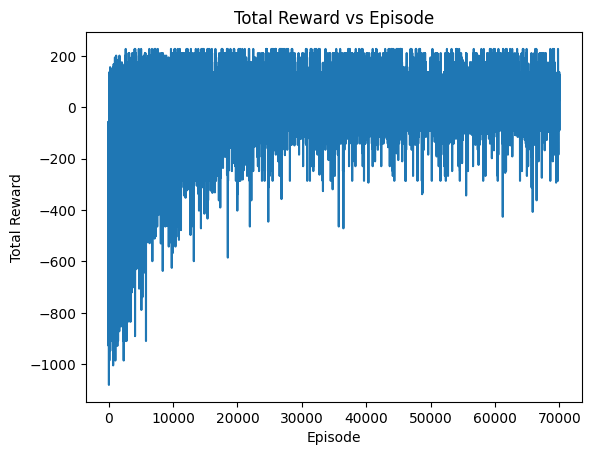

In [45]:
plt.plot(total_rewards_)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode")
plt.show()

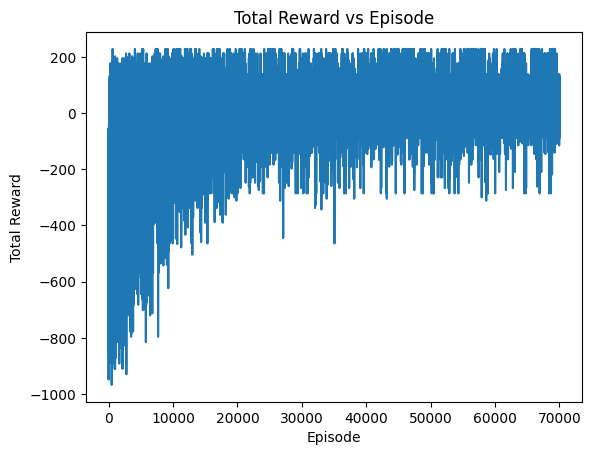

In [21]:
plt.plot(total_rewards_)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode")
plt.show()

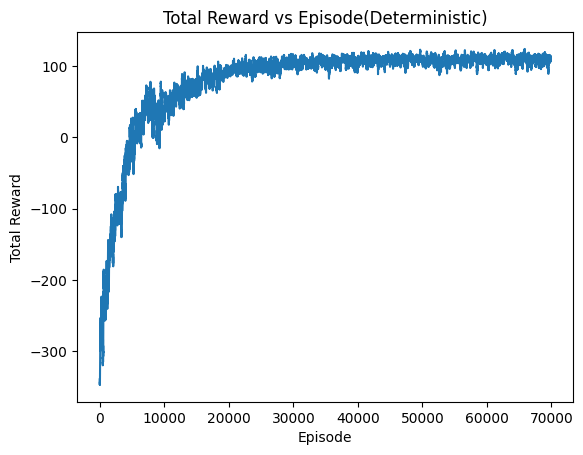

In [24]:
smoothed_rewards = np.convolve(total_rewards_, np.ones(100)/100, mode="valid")
plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(Deterministic)")
plt.show()

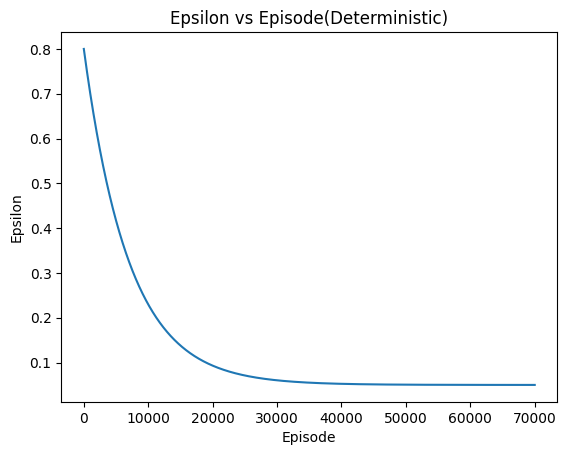

In [46]:
plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode(Deterministic)")
plt.show()

In [25]:
with open("Q_table_deterministic.pkl", "rb") as f:
    q_table = pickle.load(f)
def evaluate(env, q_table, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_idx = state_index(state, env)
            action = np.argmax(q_table[state_idx, :])  # Greedy action
            next_state, reward, terminated, truncated, done = env.step(action)
            total_reward += reward
            state = next_state

            if terminated or done:
                break

        total_rewards.append(total_reward)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o', linestyle='-', color='b')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode (Greedy Policy)")
    plt.grid()
    plt.show()

    return total_rewards


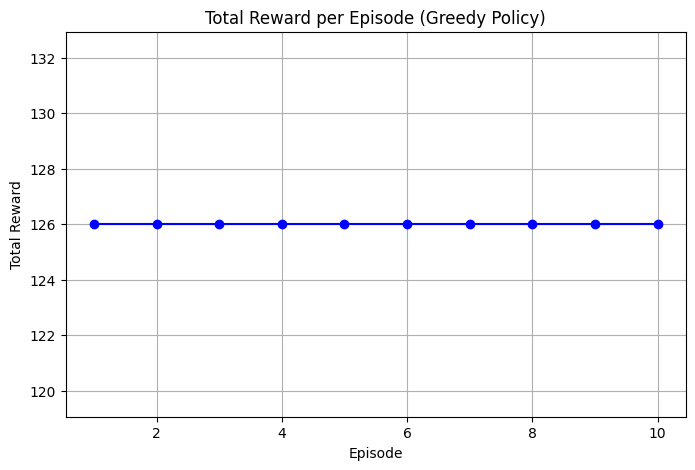

[126, 126, 126, 126, 126, 126, 126, 126, 126, 126]

In [26]:
evaluate(env, q_table)

In [91]:
def render_env(env, frame_num):
    fig = env.render()  # Get the figure from render
    filename = f"frames_deter/frame_{frame_num:03d}.png"
    fig.savefig(filename, bbox_inches='tight')  # Save frame as an image
    plt.close(fig)
env = EnvWareHouseDet()
def run_greedy_episode(env, q_table):
    state = env.reset()
    total_reward = 0
    done = False
    frame_num = 0
    frames = []

    while not done:
        # Render and save the environment frame
        render_env(env, frame_num)
        frame_path = f"frames/frame_{frame_num:03d}.png"
        frames.append(frame_path)
        frame_num += 1

        # Select greedy action
        state_idx = state_index(state, env)
        action = np.argmax(q_table[state_idx, :])  # Exploit best action
        next_state, reward, terminated, truncated, done = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or done:
            break

    print(f"Total reward for the episode: {total_reward}")

    # Create video from saved frames
    create_video(frames, "episode_run_deterministic.mp4")

def create_video(frame_paths, output_path, fps=2):
    """ Combines frames into a video """
    if not frame_paths:
        print("No frames found to create video.")
        return

    # Read the first frame to get dimensions
    first_frame = cv2.imread(frame_paths[0])
    height, width, layers = first_frame.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_path in frame_paths:
        img = cv2.imread(frame_path)
        video.write(img)

    video.release()
    print(f"Video saved at {output_path}")


In [92]:
run_greedy_episode(env, q_table)

Total reward for the episode: 107
Video saved at episode_run_deterministic.mp4


Stochastic Q learning

In [63]:
epsilon_stop_threshold = 0.050  # Stop training when epsilon reaches this value
env = EnvWareHouseSto()
total_rewards_ = []
epsilon_values = []
num_episodes = 70000
max_steps = 10
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = int(carry)
    return pos_index + carry_bit * (env.grid * env.grid)
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        action = choose_action(state, env)
        next_state, reward, terminated, truncated, done = env.step(action)

        update_q_table(state, action, reward, next_state)

        state = next_state
        total_reward += reward
        if done or terminated:
            break

    total_rewards_.append(total_reward)

    # Decay epsilon
    # epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon = epsilon_min + (0.8 - epsilon_min) * np.exp(-episode / (num_episodes / 10))

    epsilon_values.append(epsilon)

    # Stop training when epsilon stops decreasing and reaches 0.050
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")
with open("Q_table_stochastic.pkl", "wb") as f:
    pickle.dump(q_table, f)

Episode 100/70000 | Total Reward: -663.00 | Epsilon: 0.7895
Episode 200/70000 | Total Reward: 75.00 | Epsilon: 0.7790
Episode 300/70000 | Total Reward: -226.00 | Epsilon: 0.7686
Episode 400/70000 | Total Reward: -568.00 | Epsilon: 0.7584
Episode 500/70000 | Total Reward: -663.00 | Epsilon: 0.7484
Episode 600/70000 | Total Reward: 143.00 | Epsilon: 0.7385
Episode 700/70000 | Total Reward: 96.00 | Epsilon: 0.7287
Episode 800/70000 | Total Reward: -340.00 | Epsilon: 0.7191
Episode 900/70000 | Total Reward: -55.00 | Epsilon: 0.7096
Episode 1000/70000 | Total Reward: -397.00 | Epsilon: 0.7003
Episode 1100/70000 | Total Reward: 49.00 | Epsilon: 0.6910
Episode 1200/70000 | Total Reward: -359.00 | Epsilon: 0.6819
Episode 1300/70000 | Total Reward: -55.00 | Epsilon: 0.6730
Episode 1400/70000 | Total Reward: -29.00 | Epsilon: 0.6641
Episode 1500/70000 | Total Reward: -55.00 | Epsilon: 0.6554
Episode 1600/70000 | Total Reward: -473.00 | Epsilon: 0.6468
Episode 1700/70000 | Total Reward: -777.00 |

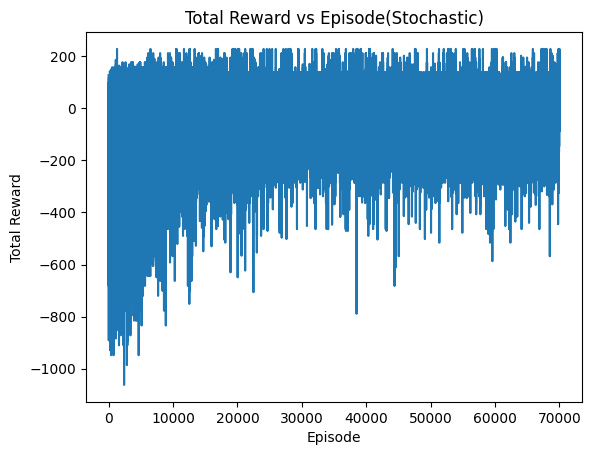

In [64]:
plt.plot(total_rewards_)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(Stochastic)")
plt.show()

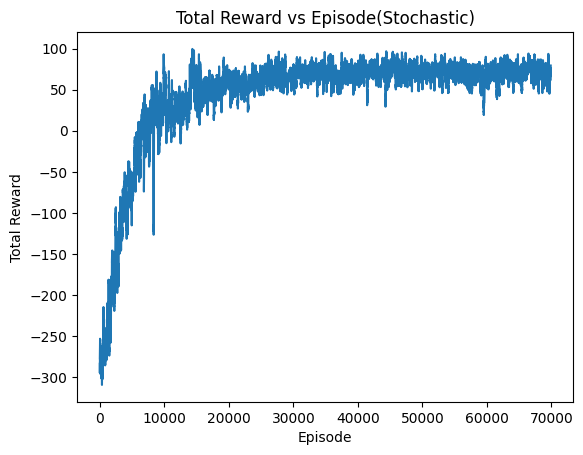

In [65]:
smoothed_rewards = np.convolve(total_rewards_, np.ones(100)/100, mode="valid")
plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(Stochastic)")
plt.show()

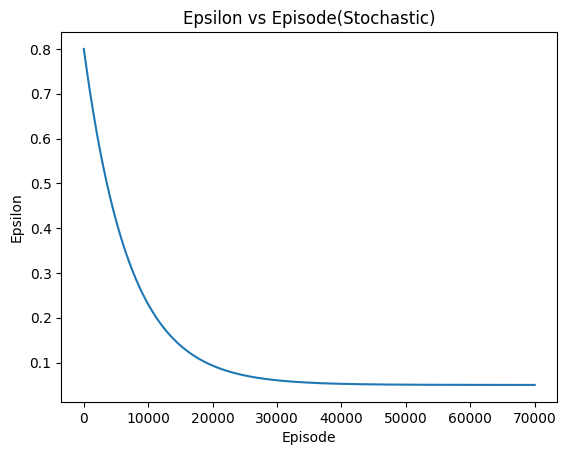

In [66]:
plt.plot(epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode(Stochastic)")
plt.show()

In [70]:
with open("Q_table_stochastic.pkl", "rb") as f:
    q_table = pickle.load(f)
def evaluate(env, q_table, num_episodes=10):
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_idx = state_index(state, env)
            action = np.argmax(q_table[state_idx, :])  # Greedy action
            next_state, reward, terminated, truncated, done = env.step(action)
            total_reward += reward
            state = next_state

            if terminated or done:
                break

        total_rewards.append(total_reward)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(total_rewards) + 1), total_rewards, marker='o', linestyle='-', color='b')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward per Episode (Greedy Policy)")
    plt.grid()
    plt.show()

    return total_rewards


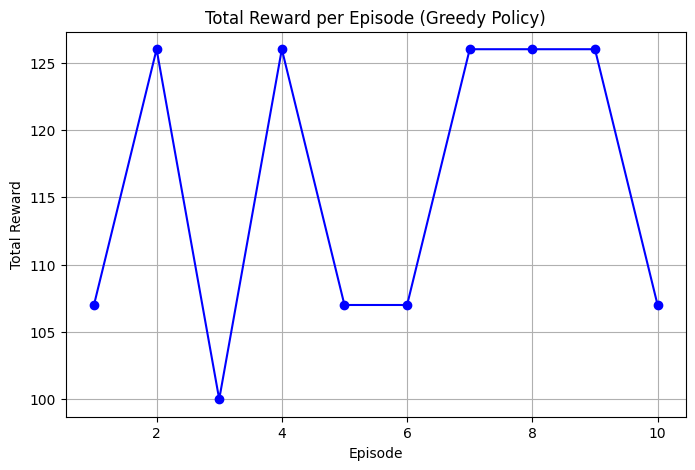

[107, 126, 100, 126, 107, 107, 126, 126, 126, 107]

In [73]:
sto = EnvWareHouseSto()
evaluate(sto, q_table)

In [109]:
def render_env(env, frame_num):
    grid_matrix = env.render()  # Get the figure from render
    # Create a figure and axes for plotting
    fig, ax = plt.subplots()

    # Plot the grid_matrix on the axes
    ax.imshow(grid_matrix, cmap="coolwarm", origin="upper")
    filename = f"frames_sto/frame_{frame_num:03d}.png"
    fig.savefig(filename, bbox_inches='tight')  # Save frame as an image
    plt.close(fig)
def run_greedy_episode(env, q_table):
    state = env.reset()
    total_reward = 0
    done = False
    frame_num = 0
    frames = []
    while not done:
      render_env(env, frame_num)
      frame_path = f"frames_sto/frame_{frame_num:03d}.png"
      frames.append(frame_path)
      frame_num += 1

      # Select greedy action
      state_idx = state_index(state, env)
      action = np.argmax(q_table[state_idx, :])  # Exploit best action
      next_state, reward, terminated, truncated, done = env.step(action)
      total_reward += reward
      state = next_state

      if terminated or done:
          break
      print(f"Total reward for the episode: {total_reward}")

    # Create video from saved frames
    create_video(frames, "episode_run_stochastic.mp4")

def create_video(frame_paths, output_path, fps=2):
    """ Combines frames into a video """
    if not frame_paths:
        print("No frames found to create video.")
        return

    # Read the first frame to get dimensions
    first_frame = cv2.imread(frame_paths[0])
    height, width, layers = first_frame.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 format
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame_path in frame_paths:
        img = cv2.imread(frame_path)
        video.write(img)

    video.release()
    print(f"Video saved at {output_path}")

Total reward for the episode: -1
Total reward for the episode: -22
Total reward for the episode: -44
Total reward for the episode: -67
Total reward for the episode: -91
Total reward for the episode: -116
Total reward for the episode: -116
Total reward for the episode: -117
Total reward for the episode: -119
Total reward for the episode: -122
Video saved at episode_run_stochastic.mp4


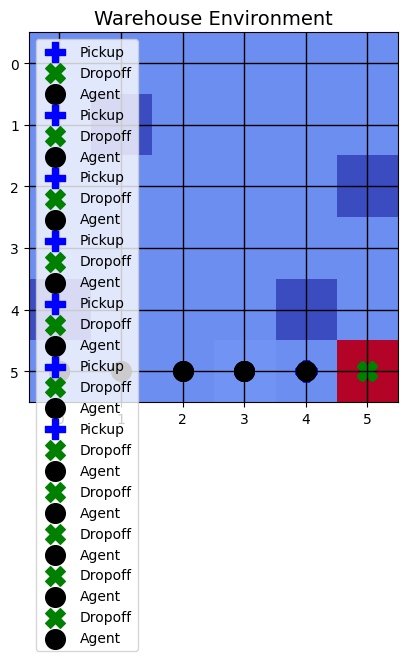

In [110]:
sto = EnvWareHouseSto()
with open("Q_table_stochastic.pkl", "rb") as f:
    q_table = pickle.load(f)
run_greedy_episode(sto, q_table)

SARSA

Deterministic

In [111]:
# Optimized Hyperparameters for SARSA
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # Slower decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
env = EnvWareHouseDet()

# Q-table initialization
state_size = env.observation_space.n
action_size = env.action_space.n
q_table = np.zeros((state_size, action_size))



# Get the index of state
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = int(carry)
    return pos_index + carry_bit * (env.grid * env.grid)

# Choose action using ε-greedy policy
def choose_action(state, env, epsilon):
    state_id = state_index(state, env)
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(q_table[state_id, :])  # Exploit

In [117]:
# SARSA Training Loop
epsilon_stop_threshold = 0.050
total_rewards_sarsa = []
epsilon_values_sarsa = []
for episode in range(num_episodes):
    state = env.reset()
    action = choose_action(state, env, epsilon)
    total_reward = 0
    done = False

    for step in range(max_steps):
        # Take action and observe next state
        next_state, reward, terminated, truncated, done = env.step(action)
        next_action = choose_action(next_state, env, epsilon)  # Choose action for next state (SARSA)

        # SARSA update rule
        state_id = state_index(state, env)
        next_state_id = state_index(next_state, env)

        td_target = reward + gamma * q_table[next_state_id, next_action]
        q_table[state_id, action] += alpha * (td_target - q_table[state_id, action])

        # Move to next state-action pair
        state, action = next_state, next_action
        total_reward += reward

        # Render and save the frame
        # render_env(env, step)

        if done or terminated:
            break

    total_rewards_sarsa.append(total_reward)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon_values_sarsa.append(epsilon)

    # Stop training if epsilon is too low
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")

# Save Q-table
with open("Q_table_SARSA.pkl", "wb") as f:
    pickle.dump(q_table, f)


Episode 100/70000 | Total Reward: 22.00 | Epsilon: 0.5160
Episode 200/70000 | Total Reward: -101.00 | Epsilon: 0.5157
Episode 300/70000 | Total Reward: -6.00 | Epsilon: 0.5155
Episode 400/70000 | Total Reward: -407.00 | Epsilon: 0.5152
Episode 500/70000 | Total Reward: -143.00 | Epsilon: 0.5150
Episode 600/70000 | Total Reward: -549.00 | Epsilon: 0.5147
Episode 700/70000 | Total Reward: 41.00 | Epsilon: 0.5145
Episode 800/70000 | Total Reward: -219.00 | Epsilon: 0.5142
Episode 900/70000 | Total Reward: 120.00 | Epsilon: 0.5139
Episode 1000/70000 | Total Reward: -348.00 | Epsilon: 0.5137
Episode 1100/70000 | Total Reward: -169.00 | Epsilon: 0.5134
Episode 1200/70000 | Total Reward: -196.00 | Epsilon: 0.5132
Episode 1300/70000 | Total Reward: -359.00 | Epsilon: 0.5129
Episode 1400/70000 | Total Reward: 125.00 | Epsilon: 0.5127
Episode 1500/70000 | Total Reward: -682.00 | Epsilon: 0.5124
Episode 1600/70000 | Total Reward: -124.00 | Epsilon: 0.5121
Episode 1700/70000 | Total Reward: -473.0

In [132]:


# Hyperparameters for Double Q-Learning
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # Slow decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
env = EnvWareHouseDet()

# Q-table initialization (Double Q-Learning uses two Q-tables)
state_size = env.observation_space.n
action_size = env.action_space.n
Q1 = np.zeros((state_size, action_size))
Q2 = np.zeros((state_size, action_size))

# Track metrics
total_rewards_dqn = []
epsilon_values_dqn = []


# Get the index of state
def state_index(state, env):
    grid_state, carry = state  # Unpack the observation space
    position = np.where(grid_state.reshape(env.grid, env.grid) == 1)  # Get agent position
    pos_index = position[0][0] * env.grid + position[1][0]  # Convert (x, y) to a single index
    carry_bit = int(carry)
    return pos_index + carry_bit * (env.grid * env.grid)

# Choose action using ε-greedy policy
def choose_action(state, env, epsilon):
    state_id = state_index(state, env)
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(Q1[state_id, :] + Q2[state_id, :])  # Exploit (sum of both Q-tables)



# Double Q-Learning Training Loop
epsilon_stop_threshold = 0.050

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    for step in range(max_steps):
        state_id = state_index(state, env)
        action = choose_action(state, env, epsilon)

        # Take action and observe next state
        next_state, reward, terminated, truncated, done = env.step(action)
        next_state_id = state_index(next_state, env)

        # Double Q-Learning Update Rule
        if np.random.rand() < 0.5:
            best_action = np.argmax(Q1[next_state_id, :])
            Q1[state_id, action] += alpha * (reward + gamma * Q2[next_state_id, best_action] - Q1[state_id, action])
        else:
            best_action = np.argmax(Q2[next_state_id, :])
            Q2[state_id, action] += alpha * (reward + gamma * Q1[next_state_id, best_action] - Q2[state_id, action])

        state = next_state
        total_reward += reward


        if done or terminated:
            break

    total_rewards_dqn.append(total_reward)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon_values_dqn.append(epsilon)

    # Stop training if epsilon is too low
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")

# Save Q-tables
with open("Q1_DoubleQ.pkl", "wb") as f:
    pickle.dump(Q1, f)
with open("Q2_DoubleQ.pkl", "wb") as f:
    pickle.dump(Q2, f)



Episode 100/70000 | Total Reward: -13.00 | Epsilon: 0.7996
Episode 200/70000 | Total Reward: -416.00 | Epsilon: 0.7992
Episode 300/70000 | Total Reward: -796.00 | Epsilon: 0.7988
Episode 400/70000 | Total Reward: -910.00 | Epsilon: 0.7984
Episode 500/70000 | Total Reward: -321.00 | Epsilon: 0.7980
Episode 600/70000 | Total Reward: -111.00 | Epsilon: 0.7976
Episode 700/70000 | Total Reward: -226.00 | Epsilon: 0.7972
Episode 800/70000 | Total Reward: -302.00 | Epsilon: 0.7968
Episode 900/70000 | Total Reward: -16.00 | Epsilon: 0.7964
Episode 1000/70000 | Total Reward: -416.00 | Epsilon: 0.7960
Episode 1100/70000 | Total Reward: -188.00 | Epsilon: 0.7956
Episode 1200/70000 | Total Reward: -85.00 | Epsilon: 0.7952
Episode 1300/70000 | Total Reward: -245.00 | Epsilon: 0.7948
Episode 1400/70000 | Total Reward: -55.00 | Epsilon: 0.7944
Episode 1500/70000 | Total Reward: -302.00 | Epsilon: 0.7940
Episode 1600/70000 | Total Reward: -54.00 | Epsilon: 0.7936
Episode 1700/70000 | Total Reward: -55

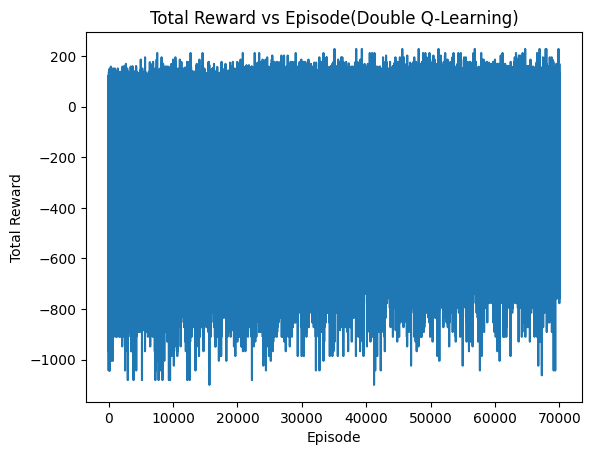

In [119]:
plt.plot(total_rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(Double Q-Learning)")
plt.show()

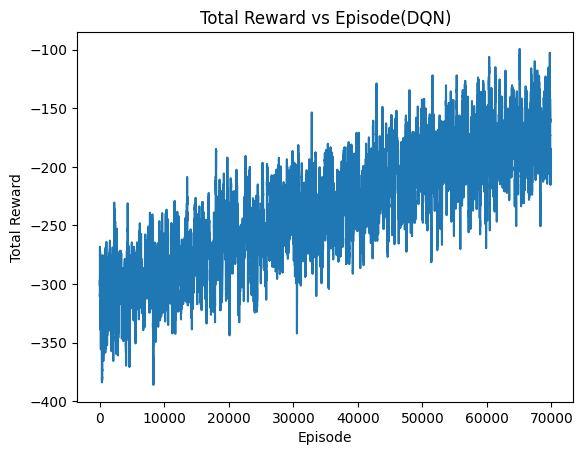

In [120]:
smoothed_rewards = np.convolve(total_rewards_dqn, np.ones(100)/100, mode="valid")
plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(DQN)")
plt.show()

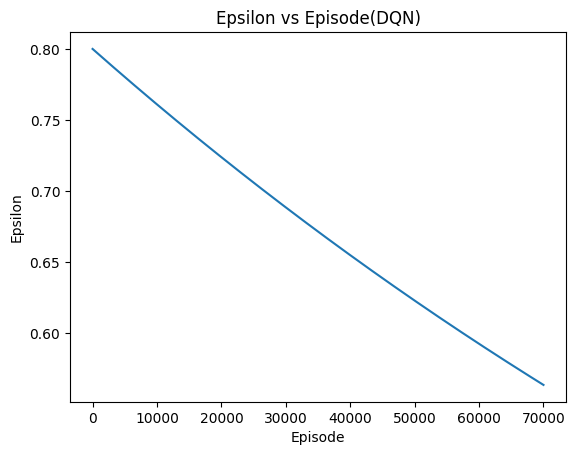

In [121]:
plt.plot(epsilon_values_dqn)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode(DQN)")
plt.show()

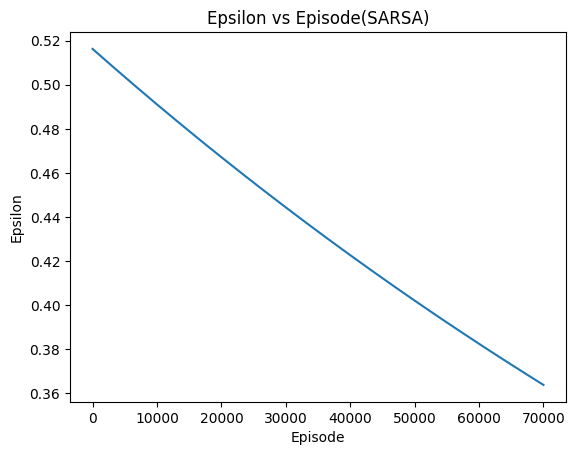

In [122]:
plt.plot(epsilon_values_sarsa)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon vs Episode(SARSA)")
plt.show()

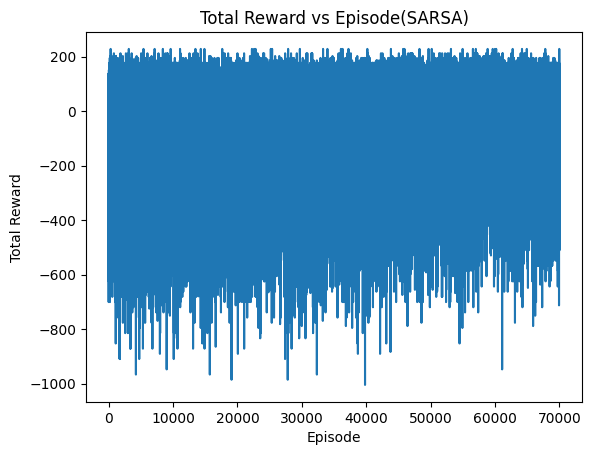

In [123]:
plt.plot(total_rewards_sarsa)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(SARSA)")
plt.show()

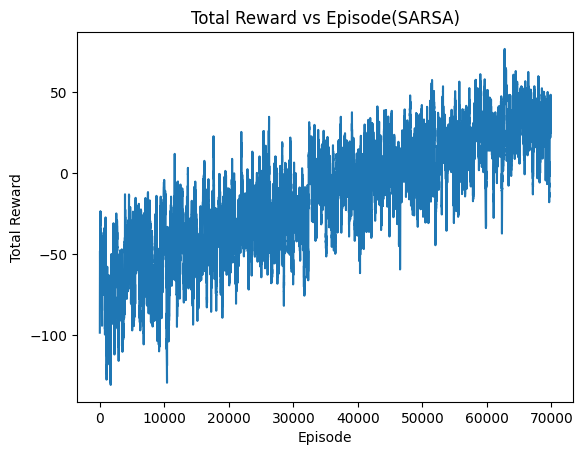

In [124]:
smoothed_rewards_sarsa = np.convolve(total_rewards_sarsa, np.ones(100)/100, mode="valid")
plt.plot(smoothed_rewards_sarsa)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(SARSA)")
plt.show()

HyperPArameter tuning Deterministic Environment

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

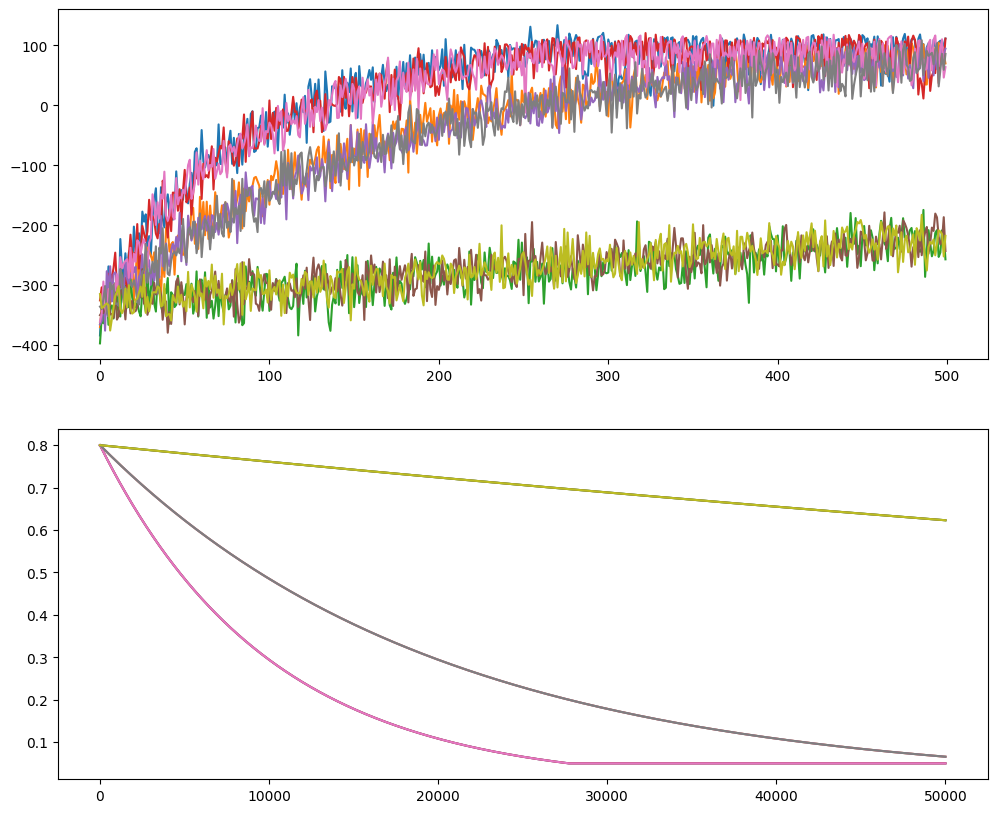

In [129]:


# Define hyperparameter values to test
gamma_values = [0.9, 0.95, 0.99]  # Discount factor
epsilon_decay_values = [0.9999, 0.99995, 0.999995]  # Exploration decay rate

def train_q_learning(env, gamma, epsilon_decay, num_episodes=50000, alpha=0.7, epsilon=0.8, epsilon_min=0.05, max_steps=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))
    total_rewards = []
    epsilon_values = []

    def state_index(state, env):
        grid_state, carry = state  # Unpack observation
        position = np.where(grid_state.reshape(env.grid, env.grid) == 1)
        pos_index = position[0][0] * env.grid + position[1][0]
        carry_bit = 1 if carry else 0
        return pos_index + carry_bit * (env.grid * env.grid)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            state_id = state_index(state, env)
            action = np.argmax(q_table[state_id, :]) if np.random.rand() > epsilon else env.action_space.sample()
            next_state, reward, terminated, truncated, done = env.step(action)

            next_state_id = state_index(next_state, env)
            best_next_action = np.argmax(q_table[next_state_id, :])
            q_table[state_id, action] += alpha * (reward + gamma * q_table[next_state_id, best_next_action] - q_table[state_id, action])

            state = next_state
            total_reward += reward
            if done or terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return total_rewards, epsilon_values, q_table

# Run experiments and plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        env = EnvWareHouseDet()
        total_rewards, epsilon_values, q_table = train_q_learning(env, gamma, epsilon_decay)
        smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

        # Plot the averaged rewards
        axes[0].plot(smoothed_rewards, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Plot epsilon decay over episodes
        axes[1].plot(epsilon_values, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Save Q-table for best model
        with open(f'Q_table_gamma_{gamma}_epsilon_{epsilon_decay}.pkl', 'wb') as f:
            pickle.dump(q_table, f)
axes.set_title("Deterministic Environment")
axes[0].set_title("Total Rewards per Episode")
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("Total Reward")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Epsilon Decay over Episodes")
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon Value")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

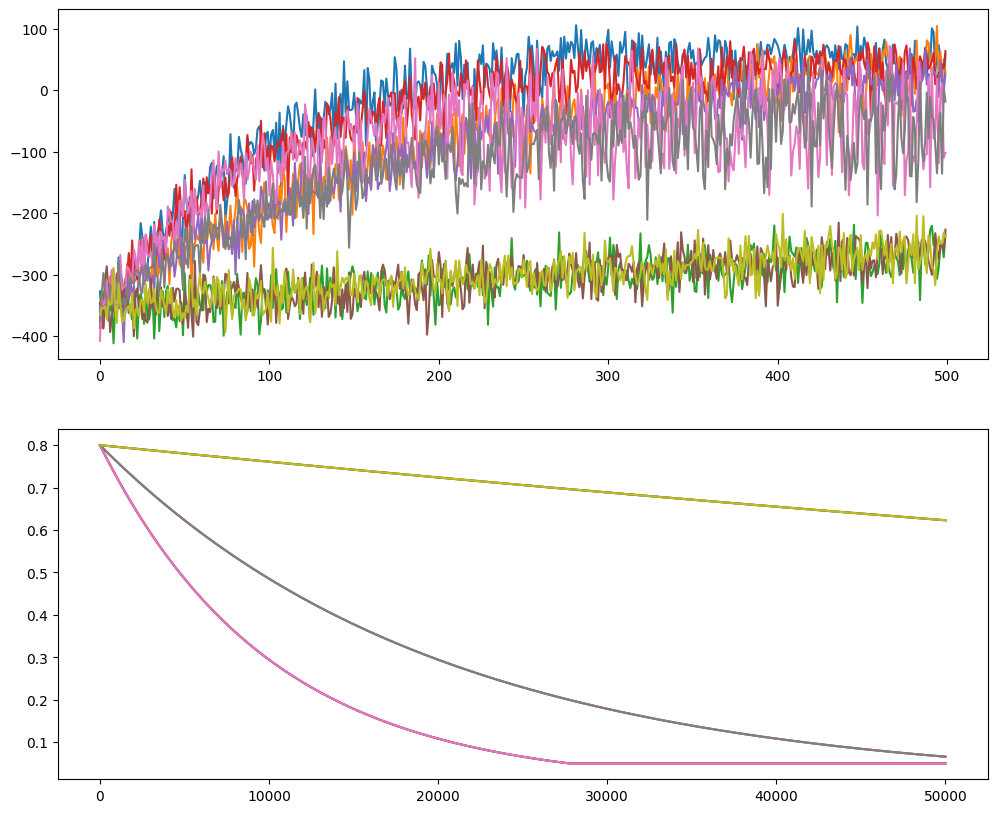

In [130]:


# Define hyperparameter values to test
gamma_values = [0.9, 0.95, 0.99]  # Discount factor
epsilon_decay_values = [0.9999, 0.99995, 0.999995]  # Exploration decay rate

def train_q_learning(env, gamma, epsilon_decay, num_episodes=50000, alpha=0.7, epsilon=0.8, epsilon_min=0.05, max_steps=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))
    total_rewards = []
    epsilon_values = []

    def state_index(state, env):
        grid_state, carry = state  # Unpack observation
        position = np.where(grid_state.reshape(env.grid, env.grid) == 1)
        pos_index = position[0][0] * env.grid + position[1][0]
        carry_bit = 1 if carry else 0
        return pos_index + carry_bit * (env.grid * env.grid)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        for step in range(max_steps):
            state_id = state_index(state, env)
            action = np.argmax(q_table[state_id, :]) if np.random.rand() > epsilon else env.action_space.sample()
            next_state, reward, terminated, truncated, done = env.step(action)

            next_state_id = state_index(next_state, env)
            best_next_action = np.argmax(q_table[next_state_id, :])
            q_table[state_id, action] += alpha * (reward + gamma * q_table[next_state_id, best_next_action] - q_table[state_id, action])

            state = next_state
            total_reward += reward
            if done or terminated:
                break

        total_rewards.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        epsilon_values.append(epsilon)

    return total_rewards, epsilon_values, q_table

# Run experiments and plot results
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
for gamma in gamma_values:
    for epsilon_decay in epsilon_decay_values:
        env = EnvWareHouseSto()
        total_rewards, epsilon_values, q_table = train_q_learning(env, gamma, epsilon_decay)
        smoothed_rewards = np.mean(np.array(total_rewards).reshape(-1, 100), axis=1)

        # Plot the averaged rewards
        axes[0].plot(smoothed_rewards, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Plot epsilon decay over episodes
        axes[1].plot(epsilon_values, label=f'γ={gamma}, ε_decay={epsilon_decay}')

        # Save Q-table for best model
        with open(f'Q_table_gamma_{gamma}_epsilon_{epsilon_decay}.pkl', 'wb') as f:
            pickle.dump(q_table, f)
axes.set_title("Stochastic Environment")
axes[0].set_title("Total Rewards per Episode")
axes[0].set_xlabel("Episodes")
axes[0].set_ylabel("Total Reward")
axes[0].legend()
axes[0].grid()

axes[1].set_title("Epsilon Decay over Episodes")
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Epsilon Value")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


In [133]:
# Hyperparameters for Double Q-Learning
alpha = 0.7            # Learning rate
gamma = 0.99           # Discount factor
epsilon = 0.8          # Initial exploration rate
epsilon_decay = 0.999995 # Slow decay for extended exploration
epsilon_min = 0.05     # Minimum exploration rate
num_episodes = 70000   # More episodes for better training
max_steps = 10         # Max steps per episode
# SARSA Training Loop
epsilon_stop_threshold = 0.050
total_rewards_sarsa = []
epsilon_values_sarsa = []
env = EnvWareHouseSto()
for episode in range(num_episodes):
    state = env.reset()
    action = choose_action(state, env, epsilon)
    total_reward = 0
    done = False

    for step in range(max_steps):
        # Take action and observe next state
        next_state, reward, terminated, truncated, done = env.step(action)
        next_action = choose_action(next_state, env, epsilon)  # Choose action for next state (SARSA)

        # SARSA update rule
        state_id = state_index(state, env)
        next_state_id = state_index(next_state, env)

        td_target = reward + gamma * q_table[next_state_id, next_action]
        q_table[state_id, action] += alpha * (td_target - q_table[state_id, action])

        # Move to next state-action pair
        state, action = next_state, next_action
        total_reward += reward

        # Render and save the frame
        # render_env(env, step)

        if done or terminated:
            break

    total_rewards_sarsa.append(total_reward)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    epsilon_values_sarsa.append(epsilon)

    # Stop training if epsilon is too low
    if epsilon <= epsilon_stop_threshold:
        print(f"Training stopped at Episode {episode+1} as epsilon reached {epsilon:.3f}")
        break

    # Print progress every 100 episodes
    if (episode + 1) % 100 == 0:
        print(f"Episode {episode+1}/{num_episodes} | Total Reward: {total_reward:.2f} | Epsilon: {epsilon:.4f}")

# Save Q-table
with open("Q_table_SARSA.pkl", "wb") as f:
    pickle.dump(q_table, f)


Episode 100/70000 | Total Reward: -378.00 | Epsilon: 0.7996
Episode 200/70000 | Total Reward: -283.00 | Epsilon: 0.7992
Episode 300/70000 | Total Reward: -530.00 | Epsilon: 0.7988
Episode 400/70000 | Total Reward: -454.00 | Epsilon: 0.7984
Episode 500/70000 | Total Reward: -226.00 | Epsilon: 0.7980
Episode 600/70000 | Total Reward: -416.00 | Epsilon: 0.7976
Episode 700/70000 | Total Reward: -416.00 | Epsilon: 0.7972
Episode 800/70000 | Total Reward: -245.00 | Epsilon: 0.7968
Episode 900/70000 | Total Reward: -264.00 | Epsilon: 0.7964
Episode 1000/70000 | Total Reward: -568.00 | Epsilon: 0.7960
Episode 1100/70000 | Total Reward: -131.00 | Epsilon: 0.7956
Episode 1200/70000 | Total Reward: -55.00 | Epsilon: 0.7952
Episode 1300/70000 | Total Reward: -340.00 | Epsilon: 0.7948
Episode 1400/70000 | Total Reward: -473.00 | Epsilon: 0.7944
Episode 1500/70000 | Total Reward: -55.00 | Epsilon: 0.7940
Episode 1600/70000 | Total Reward: -283.00 | Epsilon: 0.7936
Episode 1700/70000 | Total Reward: 

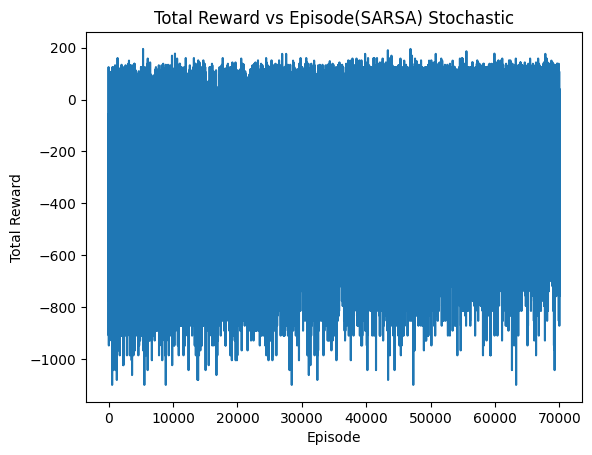

In [134]:
plt.plot(total_rewards_sarsa)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(SARSA) Stochastic")
plt.show()


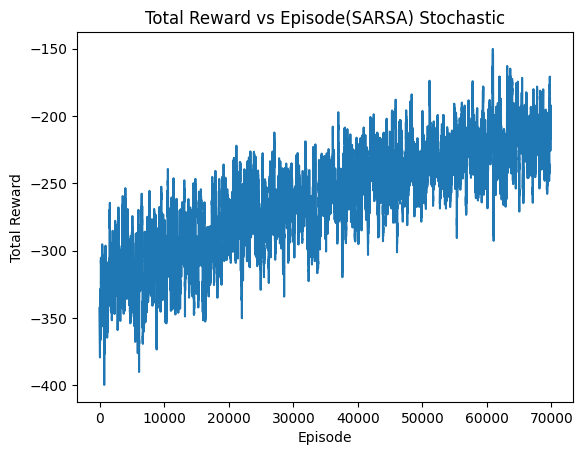

In [135]:
smoothed_rewards_sarsa = np.convolve(total_rewards_sarsa, np.ones(100)/100, mode="valid")
plt.plot(smoothed_rewards_sarsa)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episode(SARSA) Stochastic")
plt.show()